In [1]:
!python -V

Python 3.9.0


In [4]:
from compare import *
from lava_generator import *
from xai import latent_space_display_mark

In [9]:
vae = VAE.load("trained_models/VAE")
cnn = load_model("trained_models/CNN/classifier.h5")
xai = xai_model(vae.decoder, cnn, input_shape=(12,))

# input images
# samples_test, sample_labels_test = load_samples_for_test_folder(img_dir='./contrib/DLFuzz/MNIST/seeds_50')
samples_test, sample_labels_test = load_samples_for_test(200)

# prepare
view_samples = samples_test
view_sample_labels = sample_labels_test
# view_samples = samples
# view_sample_labels = sample_labels

x_view = np.reshape(view_samples, (-1, 784))
y_view_onehot = tf.one_hot(tf.constant(view_sample_labels), depth=10).numpy()
h_view = vae.encoder.predict(x_view)

K.set_learning_phase(0)
dlfuzz = DLFuzz(cnn)

7/7 [==============================] - 0s 6ms/step


/opt/anaconda3/envs/bachelor/lib/python3.9/site-packages/keras/backend.py:450: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn('`tf.keras.backend.set_learning_phase` is deprecated and '


In [12]:
def generate_adversarial_with_gradient_descent(h_view, label, alpha, num_iterations):
    # h_view: latent space
    # load models
    vae = VAE.load("trained_models/VAE")
    cnn = load_model("trained_models/CNN/classifier.h5")
    xai = xai_model(vae.decoder, cnn, input_shape=(12,))

    # prepare data
    x = np.array([h_view])
    y = np.array([label])

    # Adversarial example generation
    for iteration in range(num_iterations):
        gradient = gradient_of_x(x, y, xai)  # Compute gradient
        x_tmp = x + alpha * gradient  # Update the encoded image with the gradient
        decoded_image = vae.decoder.predict(x_tmp).reshape((28, 28, 1))  # Decode the perturbed image

        # Check if the decoded image is misclassified by the CNN
        prediction = cnn.predict(np.array([decoded_image]))[0]
        predicted_label = np.argmax(prediction)

        if predicted_label != np.argmax(y):
            # step back and try finer alpha
            inner_alpha = alpha / num_iterations
            for inner_iteration in range(num_iterations):
                gradient = gradient_of_x(x, y, xai)  # Compute gradient
                inner_x_tmp = x + inner_alpha * gradient  # Update the encoded image with the gradient
                decoded_image = vae.decoder.predict(inner_x_tmp).reshape((28, 28, 1))  # Decode the perturbed image

                # Check if the decoded image is misclassified by the CNN
                prediction = cnn.predict(np.array([decoded_image]))[0]
                predicted_label = np.argmax(prediction)

                if predicted_label != np.argmax(y):
                    print(f"Misclassification achieved at iteration {iteration},  inner iteration {inner_iteration}")
                    break
                x = inner_x_tmp

        if predicted_label != np.argmax(y):
            break
        x = x_tmp;
    return [decoded_image, predicted_label]


1/1 [==============================] - 0s 132ms/step


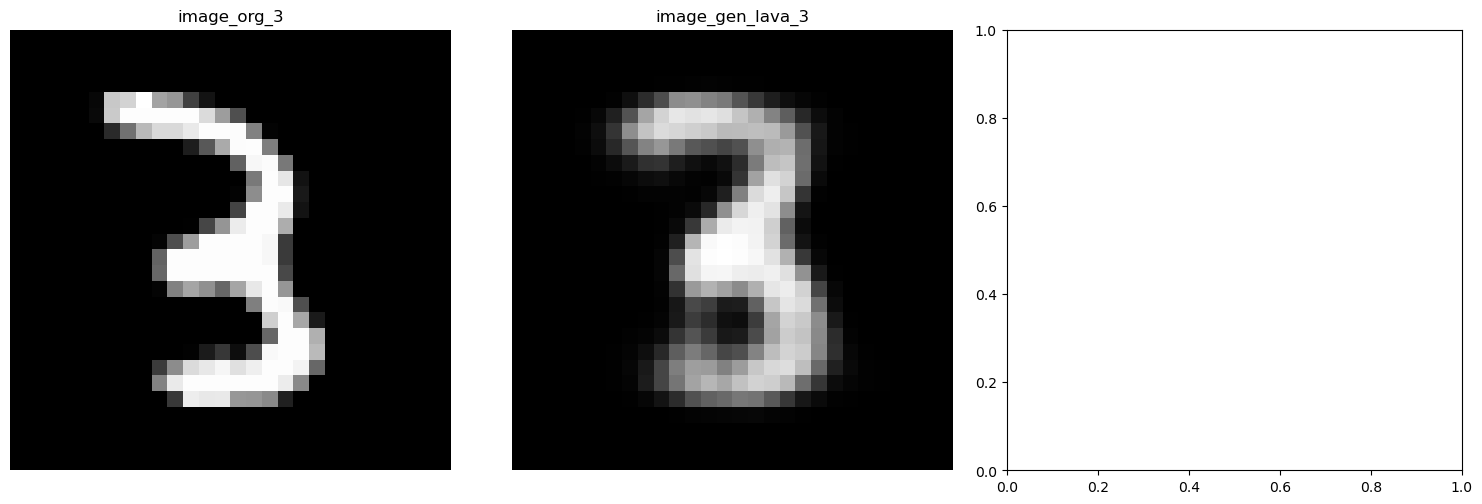

In [13]:
# calculate latent variant image
i = 4

image_org = np.array([view_samples[i]], dtype="float32")
label_org = view_sample_labels[i]

x = np.array([h_view[i]])
y = np.array([y_view_onehot[i]])

# Compute initial gradient
g = gradient_of_x(x, y, xai)

g_npy = np.squeeze(g.numpy())

# Parameters for gradient descent
alpha = 0.01  # Learning rate
num_iterations = 100  # Number of iterations for gradient descent

# Adversarial example generation
[decoded_image, prediction] = generate_adversarial_with_gradient_descent(h_view[i], y_view_onehot[i], alpha, num_iterations)

image_gen_lava = vae.decoder.predict(x)
images = [image_org, decoded_image]
titles = [f'image_org_{label_org}', f'image_gen_lava_{prediction}']
plot_image_comparison(images, titles)